In [16]:
import json
import matplotlib.pylab as plt
import matplotlib
from urllib.request import urlopen
import numpy as np

In [28]:
# Load data
file = urlopen("https://raw.githubusercontent.com/MystenLabs/fastcrypto/gh-pages/benchmarks/history/a6e3e8bceed47c3b32de60e3cd13e63c44ab7577.json")

# Structure data
data = {}

for line in file:
    bench = json.loads(line)

    if bench['reason'] != 'benchmark-complete':
        continue
    value = bench['mean']
    
    # Convert to ms
    if value['unit'] == "ns":
        value['estimate'] /= 1000;
        value['lower_bound'] /= 1000;
        value['upper_bound'] /= 1000;
        
    key = bench['id']
    description = key.split('/')
    group = description[0]

    if group not in data:
        data[group] = {}
        
    if len(description) < 2:
        continue
        
    scheme = description[1]
    if scheme not in data[group]:
        data[group][scheme] = {}
        
    # Benchmarks of batch verification has 3 parts (type/scheme/batch_size)
    if len(description) == 3:
        batch_size = int(description[2])
        data[group][scheme][batch_size] = value
    else:
        data[group][scheme] = value

In [29]:
# Return series as (x,y,low,high) where [low, high] is the 95% confidence interval given as absolute difference from the mean
def get_series(group, scheme = ''):
    tuples = data[group]
    if scheme != '':
        tuples = data[group][scheme]
    return tuples.keys(), np.array([value['estimate'] for value in tuples.values()]), np.array([value['lower_bound'] for value in tuples.values()]), np.array([value['upper_bound'] for value in tuples.values()])

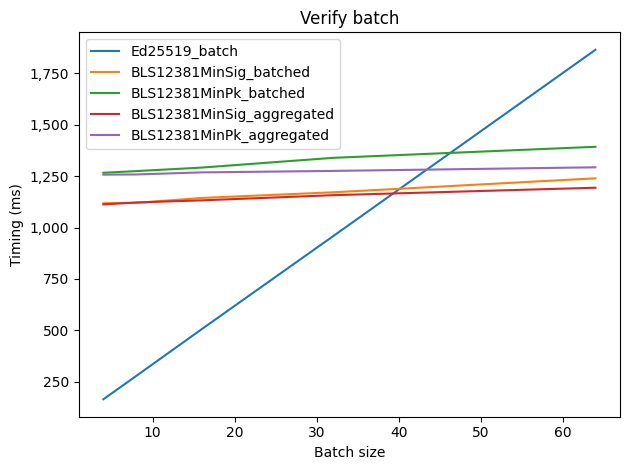

In [45]:
# Plot batch verification
group = "Verify batch"
d = data[group]

fig, ax = plt.subplots()

for scheme in d:
    if scheme.startswith("Secp256"):
        continue
    
    x, y, lower_bound, upper_bound = get_series(group, scheme)
    ax.plot(x, y, label = scheme)
    #ax.fill_between(x, lower_bound, upper_bound)

ax.set_title(group)
ax.legend(loc='upper left')
ax.set_xlabel('Batch size')
ax.set_ylabel('Timing (ms)')
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.savefig("batch-a6e3e8.svg")

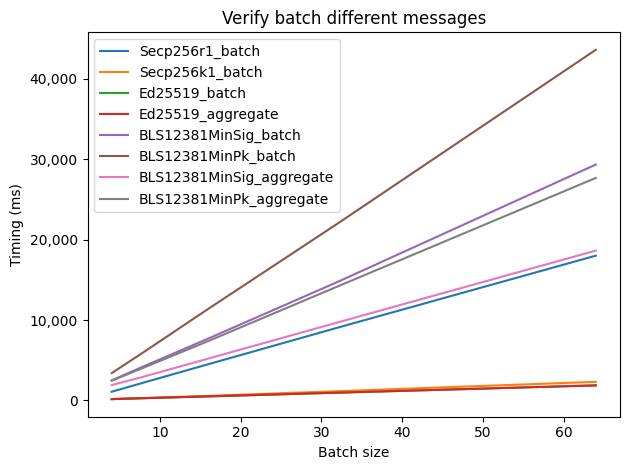

In [44]:
# Plot batch verification different messages
group = "Verify batch different messages"
d = data[group]

fig, ax = plt.subplots()

for scheme in d:
    x, y, lower_bound, upper_bound = get_series(group, scheme)
    ax.plot(x, y, label = scheme)
    #ax.fill_between(x, lower_bound, upper_bound)

ax.set_title(group)
ax.legend(loc='upper left')
ax.set_xlabel('Batch size')
ax.set_ylabel('Timing (ms)')
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.savefig("batch-a6e3e8.svg")

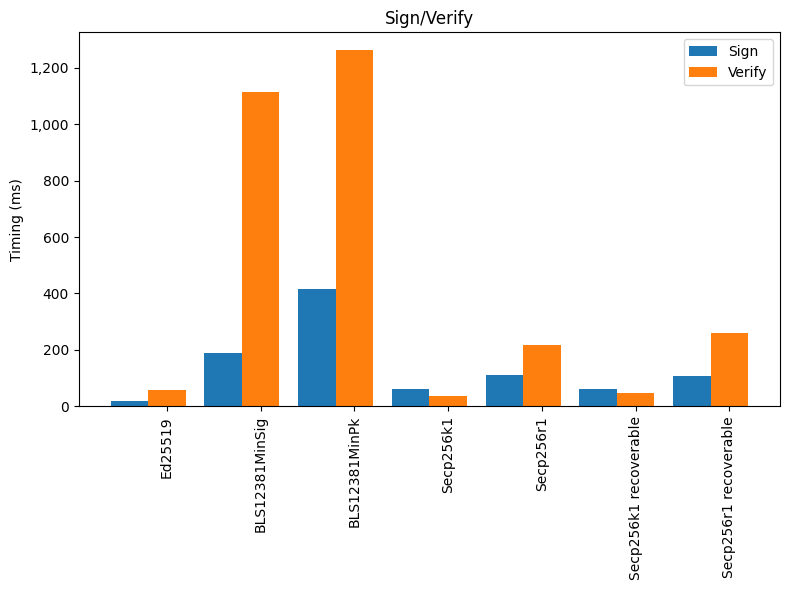

In [41]:
# Plot signing

fig, ax = plt.subplots(figsize=(8, 6))
width = 0.4

group = "Sign"
d = data[group]

schemes, y, lower_bound, upper_bound = get_series(group)
x = np.arange(len(schemes)) - width / 2
ax.bar(x, y, width, label = group)

group = "Verify"
d = data[group]
schemes, y, lower_bound, upper_bound = get_series(group)
x = np.arange(len(schemes)) + width / 2
ax.bar(x, y, width, label = group)

ax.set_title("Sign/Verify")
ax.set_ylabel('Timing (ms)')
ax.legend()
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylim(ymin=0)

ax.set_xticks(x, d.keys());
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig("signatures-a6e3e8.svg")